# Deep Convolutional Generative Adversarial Network


## Reference: https://www.kaggle.com/sani84

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

# PARAMETERS 

In [7]:
n_images = 1024
batch_size = 128
latent_dim = 100
n_epoch = 100
img_shape = (128, 128, 3)

In [8]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/' 
images = os.listdir(data_dir)
images = images[:n_images]

# PLOT IMAGES

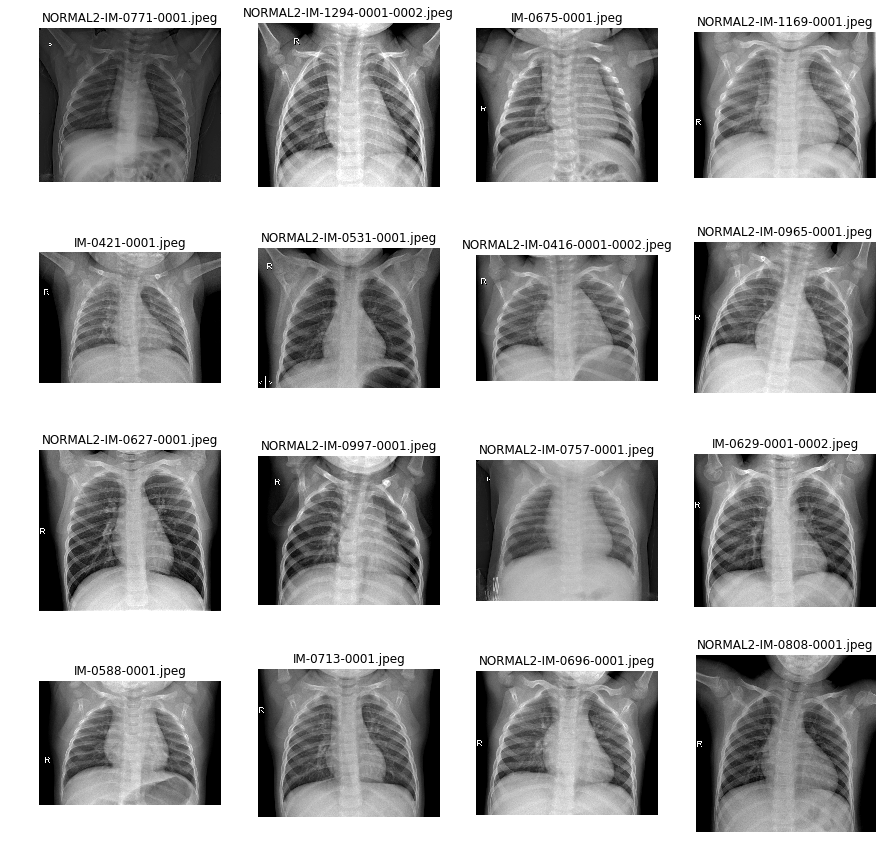

In [9]:
plt.figure(figsize=(15,15))
for i, name in enumerate(images[:16]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir + '/' + name)
    plt.imshow(img, cmap='gray')
    plt.title(name)
    plt.axis('off')

# GET DATA 

In [10]:
def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(data_dir + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    #X = (X - 127.5) / 127.5
    X = X / 255
    return X

dataset = get_data(images)

# DISCRIMINATOR 

In [11]:
def define_discriminator(in_shape=(128,128,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 64x64
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# GENERATOR 

In [12]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

# GAN 

In [13]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images
def show_generated(generated,epoch, n=5):
    #[-1,1] -> [0,1] 
    #generated = (generated + 1)/ 2
    #generated = (generated[:n*n] * 127.5) + 127.5
    #generated = generated * 255
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        #img = plt.imread(data_dir + '/' + name)
        plt.imshow(generated[i])
        #plt.title(name)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    # show plot
    show_generated(x_fake, epoch)    

# TRAIN 

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    start = time.time()
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        # evaluate the model performance
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1,  Loss: D_real = 0.072, D_fake = 0.938,  G = 0.648
Epoch: 2,  Loss: D_real = 0.017, D_fake = 0.583,  G = 0.986
Epoch: 3,  Loss: D_real = 0.000, D_fake = 0.003,  G = 11.561
Epoch: 4,  Loss: D_real = 0.006, D_fake = 0.077,  G = 3.113
Epoch: 5,  Loss: D_real = 0.018, D_fake = 0.182,  G = 3.674
Epoch: 6,  Loss: D_real = 0.033, D_fake = 0.561,  G = 0.908
Epoch: 7,  Loss: D_real = 0.027, D_fake = 0.194,  G = 1.949
Epoch: 8,  Loss: D_real = 0.106, D_fake = 0.900,  G = 0.992
Epoch: 9,  Loss: D_real = 0.010, D_fake = 0.542,  G = 1.055
Epoch: 10,  Loss: D_real = 0.031, D_fake = 0.200,  G = 1.977
>Accuracy [real: 99%, fake: 100%]


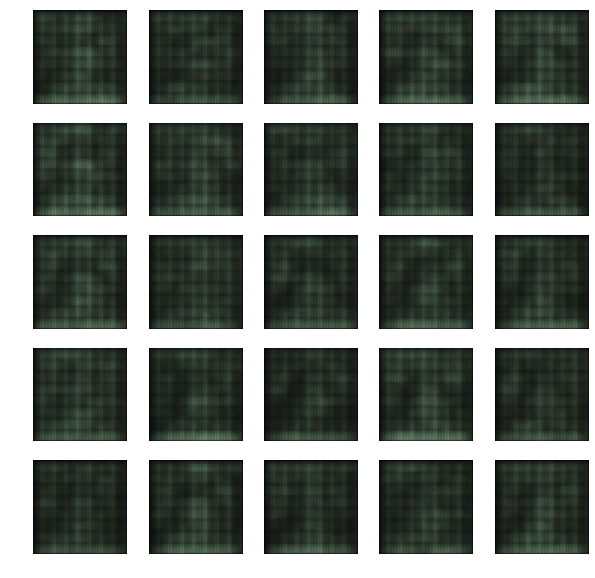

Epoch: 11,  Loss: D_real = 0.191, D_fake = 0.584,  G = 4.471
Epoch: 12,  Loss: D_real = 0.568, D_fake = 0.541,  G = 2.341
Epoch: 13,  Loss: D_real = 0.524, D_fake = 0.660,  G = 2.265
Epoch: 14,  Loss: D_real = 0.679, D_fake = 0.755,  G = 1.302
Epoch: 15,  Loss: D_real = 0.727, D_fake = 0.677,  G = 1.306
Epoch: 16,  Loss: D_real = 1.039, D_fake = 0.594,  G = 1.281
Epoch: 17,  Loss: D_real = 0.625, D_fake = 0.493,  G = 1.324
Epoch: 18,  Loss: D_real = 0.625, D_fake = 0.531,  G = 1.098
Epoch: 19,  Loss: D_real = 0.449, D_fake = 0.634,  G = 1.057
Epoch: 20,  Loss: D_real = 0.514, D_fake = 0.689,  G = 1.192
>Accuracy [real: 87%, fake: 98%]


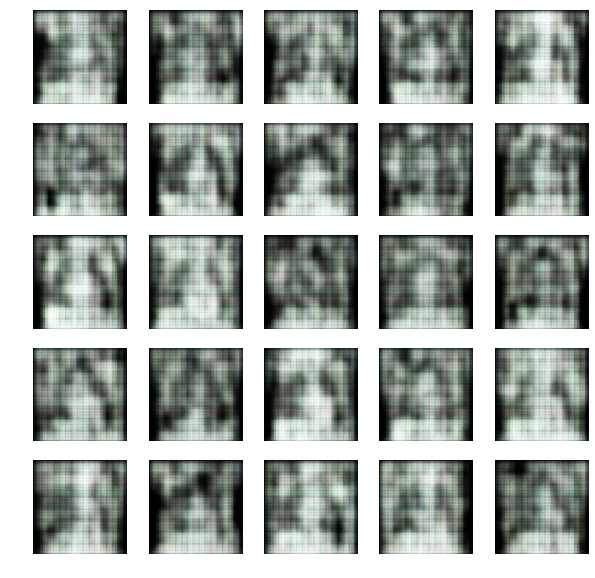

Epoch: 21,  Loss: D_real = 0.489, D_fake = 0.540,  G = 1.587
Epoch: 22,  Loss: D_real = 0.320, D_fake = 0.415,  G = 1.744
Epoch: 23,  Loss: D_real = 0.416, D_fake = 0.436,  G = 2.065
Epoch: 24,  Loss: D_real = 0.750, D_fake = 0.631,  G = 1.545
Epoch: 25,  Loss: D_real = 0.435, D_fake = 0.460,  G = 2.488
Epoch: 26,  Loss: D_real = 0.494, D_fake = 0.425,  G = 1.816
Epoch: 27,  Loss: D_real = 0.443, D_fake = 0.558,  G = 4.060
Epoch: 28,  Loss: D_real = 0.678, D_fake = 0.539,  G = 1.347
Epoch: 29,  Loss: D_real = 0.635, D_fake = 0.413,  G = 1.582
Epoch: 30,  Loss: D_real = 0.606, D_fake = 0.637,  G = 1.670
>Accuracy [real: 80%, fake: 95%]


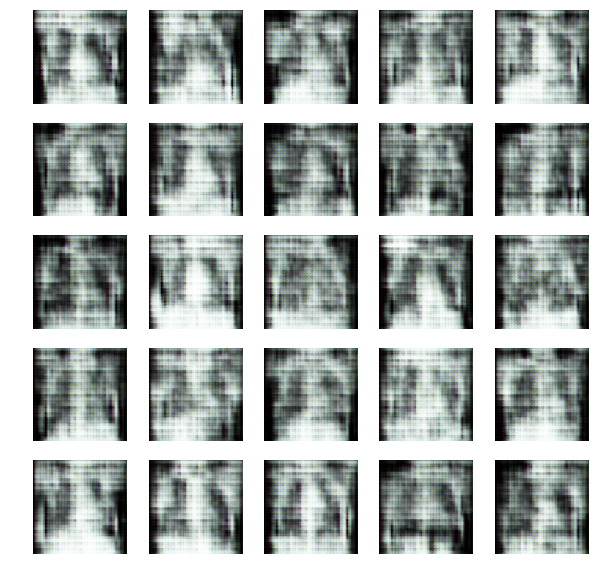

Epoch: 31,  Loss: D_real = 0.419, D_fake = 0.385,  G = 1.782
Epoch: 32,  Loss: D_real = 0.495, D_fake = 0.450,  G = 1.925
Epoch: 33,  Loss: D_real = 0.341, D_fake = 0.466,  G = 2.303
Epoch: 34,  Loss: D_real = 0.389, D_fake = 0.363,  G = 3.966
Epoch: 35,  Loss: D_real = 1.039, D_fake = 0.694,  G = 2.000
Epoch: 36,  Loss: D_real = 0.425, D_fake = 0.472,  G = 2.145
Epoch: 37,  Loss: D_real = 0.477, D_fake = 0.342,  G = 1.983
Epoch: 38,  Loss: D_real = 0.348, D_fake = 0.318,  G = 2.341
Epoch: 39,  Loss: D_real = 0.301, D_fake = 0.409,  G = 2.143
Epoch: 40,  Loss: D_real = 0.396, D_fake = 0.478,  G = 1.700
>Accuracy [real: 90%, fake: 96%]


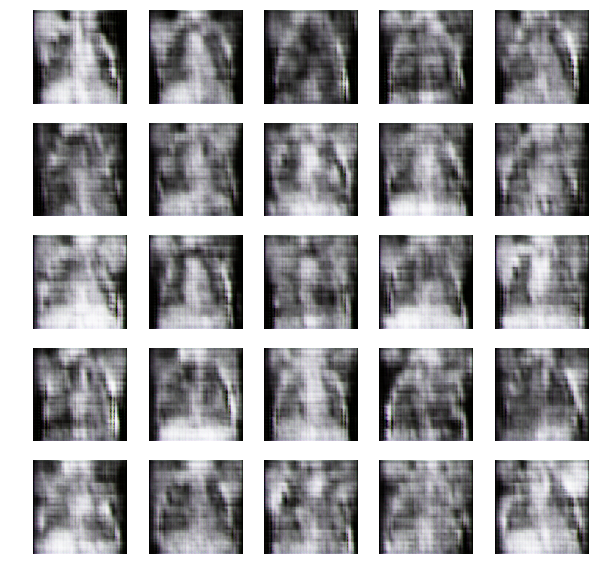

Epoch: 41,  Loss: D_real = 0.310, D_fake = 0.320,  G = 2.502
Epoch: 42,  Loss: D_real = 0.211, D_fake = 0.170,  G = 3.085
Epoch: 43,  Loss: D_real = 0.384, D_fake = 0.231,  G = 2.536
Epoch: 44,  Loss: D_real = 0.202, D_fake = 0.224,  G = 3.368
Epoch: 45,  Loss: D_real = 0.457, D_fake = 0.535,  G = 2.119
Epoch: 46,  Loss: D_real = 0.266, D_fake = 0.213,  G = 2.832
Epoch: 47,  Loss: D_real = 0.272, D_fake = 0.193,  G = 2.996
Epoch: 48,  Loss: D_real = 1.827, D_fake = 1.290,  G = 5.402
Epoch: 49,  Loss: D_real = 0.452, D_fake = 0.674,  G = 1.096
Epoch: 50,  Loss: D_real = 0.378, D_fake = 0.406,  G = 1.511
>Accuracy [real: 91%, fake: 100%]


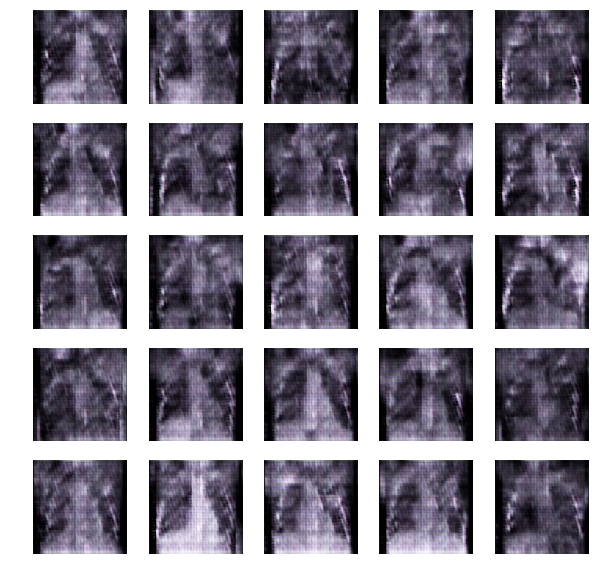

Epoch: 51,  Loss: D_real = 0.242, D_fake = 0.293,  G = 2.060
Epoch: 52,  Loss: D_real = 0.195, D_fake = 0.354,  G = 2.424
Epoch: 53,  Loss: D_real = 0.248, D_fake = 0.442,  G = 2.872
Epoch: 54,  Loss: D_real = 0.403, D_fake = 0.418,  G = 2.878
Epoch: 55,  Loss: D_real = 0.316, D_fake = 0.316,  G = 2.974
Epoch: 56,  Loss: D_real = 0.301, D_fake = 0.339,  G = 2.925
Epoch: 57,  Loss: D_real = 0.276, D_fake = 0.314,  G = 3.105
Epoch: 58,  Loss: D_real = 0.397, D_fake = 0.279,  G = 3.138
Epoch: 59,  Loss: D_real = 0.631, D_fake = 0.577,  G = 2.459
Epoch: 60,  Loss: D_real = 0.373, D_fake = 0.276,  G = 2.355
>Accuracy [real: 88%, fake: 100%]


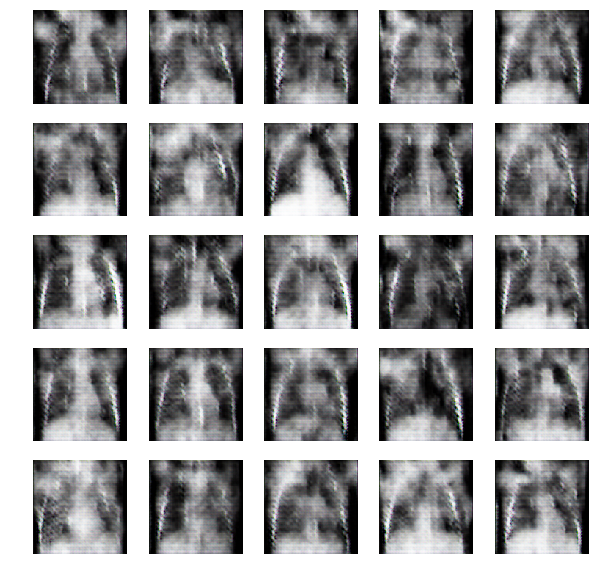

Epoch: 61,  Loss: D_real = 0.429, D_fake = 0.309,  G = 2.470
Epoch: 62,  Loss: D_real = 0.526, D_fake = 0.425,  G = 2.251
Epoch: 63,  Loss: D_real = 0.525, D_fake = 0.385,  G = 2.250
Epoch: 64,  Loss: D_real = 0.305, D_fake = 0.353,  G = 2.955
Epoch: 65,  Loss: D_real = 0.485, D_fake = 0.428,  G = 2.611
Epoch: 66,  Loss: D_real = 0.386, D_fake = 0.471,  G = 3.246
Epoch: 67,  Loss: D_real = 0.398, D_fake = 0.464,  G = 2.909
Epoch: 68,  Loss: D_real = 0.651, D_fake = 0.473,  G = 2.433
Epoch: 69,  Loss: D_real = 0.584, D_fake = 0.636,  G = 2.559
Epoch: 70,  Loss: D_real = 0.560, D_fake = 0.275,  G = 2.637
>Accuracy [real: 97%, fake: 100%]


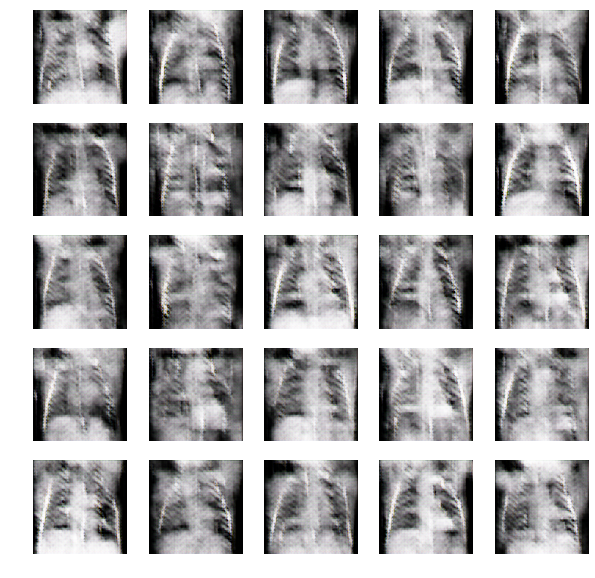

Epoch: 71,  Loss: D_real = 0.358, D_fake = 0.486,  G = 3.090
Epoch: 72,  Loss: D_real = 0.140, D_fake = 0.302,  G = 3.226
Epoch: 73,  Loss: D_real = 0.627, D_fake = 0.491,  G = 3.004
Epoch: 74,  Loss: D_real = 0.824, D_fake = 0.342,  G = 2.337
Epoch: 75,  Loss: D_real = 0.237, D_fake = 0.342,  G = 3.482
Epoch: 76,  Loss: D_real = 0.712, D_fake = 0.604,  G = 1.619
Epoch: 77,  Loss: D_real = 0.463, D_fake = 0.341,  G = 2.617
Epoch: 78,  Loss: D_real = 0.464, D_fake = 0.490,  G = 2.578
Epoch: 79,  Loss: D_real = 0.470, D_fake = 0.367,  G = 2.016
Epoch: 80,  Loss: D_real = 0.399, D_fake = 0.434,  G = 2.725
>Accuracy [real: 93%, fake: 100%]


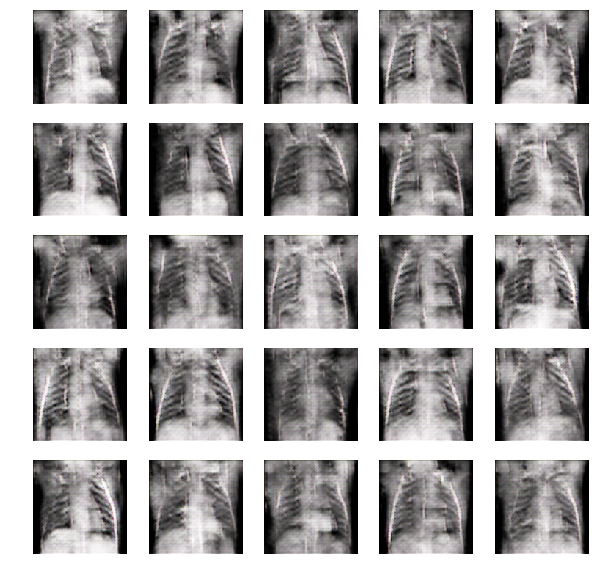

Epoch: 81,  Loss: D_real = 0.384, D_fake = 0.421,  G = 2.492
Epoch: 82,  Loss: D_real = 0.278, D_fake = 0.392,  G = 2.513
Epoch: 83,  Loss: D_real = 0.394, D_fake = 0.308,  G = 2.377
Epoch: 84,  Loss: D_real = 0.499, D_fake = 0.403,  G = 2.190
Epoch: 85,  Loss: D_real = 0.494, D_fake = 0.417,  G = 2.474
Epoch: 86,  Loss: D_real = 0.369, D_fake = 0.489,  G = 2.664
Epoch: 87,  Loss: D_real = 0.851, D_fake = 0.611,  G = 2.251
Epoch: 88,  Loss: D_real = 0.611, D_fake = 0.444,  G = 2.196
Epoch: 89,  Loss: D_real = 0.376, D_fake = 0.345,  G = 2.881
Epoch: 90,  Loss: D_real = 0.299, D_fake = 0.407,  G = 2.968
>Accuracy [real: 91%, fake: 100%]


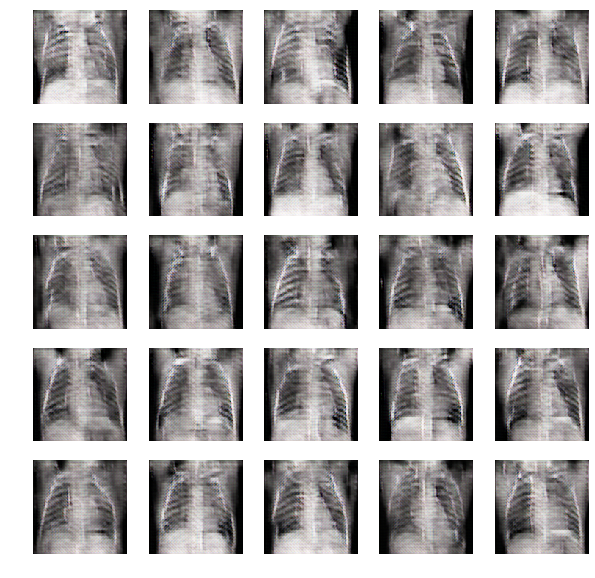

Epoch: 91,  Loss: D_real = 0.251, D_fake = 0.337,  G = 3.070
Epoch: 92,  Loss: D_real = 0.346, D_fake = 0.280,  G = 2.521
Epoch: 93,  Loss: D_real = 0.613, D_fake = 0.299,  G = 2.388
Epoch: 94,  Loss: D_real = 0.326, D_fake = 0.338,  G = 2.597
Epoch: 95,  Loss: D_real = 0.454, D_fake = 0.372,  G = 2.804
Epoch: 96,  Loss: D_real = 0.301, D_fake = 0.362,  G = 3.064
Epoch: 97,  Loss: D_real = 0.449, D_fake = 0.530,  G = 1.811
Epoch: 98,  Loss: D_real = 0.403, D_fake = 0.190,  G = 2.977
Epoch: 99,  Loss: D_real = 0.271, D_fake = 0.457,  G = 3.319
Epoch: 100,  Loss: D_real = 0.721, D_fake = 0.683,  G = 2.695
>Accuracy [real: 34%, fake: 99%]


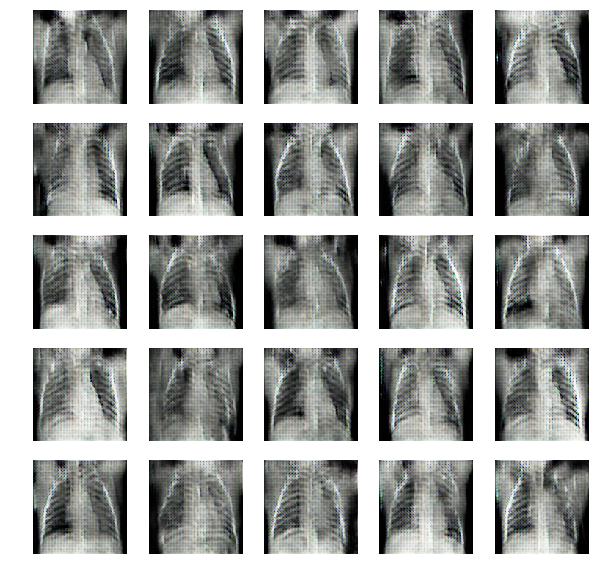

Total time for training 100 epochs is 722.4987480640411 sec


In [15]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)

## TODO: Get better output images!